In [2]:
####get gedi training data as geopandas df

import geopandas as gpd
import pandas as pd
filename = "20230125T1201__L2A__subset_saldi_06(1).gpkg"
gdf = gpd.read_file(filename)

def classify_gedi(gdf):
    gdf_c = gdf.copy()
    gdf_c.loc[gdf["Relative Height bin98 (cm)"] <= 300, 'Relative Height bin98 (cm)'] = 300
    gdf_c.loc[(gdf["Relative Height bin98 (cm)"] > 300) & (gdf["Relative Height bin98 (cm)"] <= 600), 'Relative Height bin98 (cm)'] = 600
    gdf_c.loc[(gdf["Relative Height bin98 (cm)"] > 600) & (gdf["Relative Height bin98 (cm)"] <= 1000), 'Relative Height bin98 (cm)'] = 1000
    gdf_c.loc[gdf["Relative Height bin98 (cm)"] > 1000, 'Relative Height bin98 (cm)'] = 10000
    gdf = gdf_c.replace({'Relative Height bin98 (cm)' : {300 : '<3 m', 600 : '3 - 6 m', 1000 : '6 - 10 m', 10000 : '> 10 m'}})
    return gdf

gdf_recl = classify_gedi(gdf=gdf)

def leaf_off_subset(gdf):
    gdf['Acquisition Time'] = pd.to_datetime(gdf['Acquisition Time'])
    gdf = gdf.loc[(gdf["Acquisition Time"].dt.month >= 6) & (gdf["Acquisition Time"].dt.month <= 9), :]
    return gdf

gdf_recl_lo = leaf_off_subset(gdf=gdf_recl)
gdf_lo = leaf_off_subset(gdf=gdf)

In [3]:
from sdc.load import load_product

ds = load_product(product="s1_rtc", vec="geo419b_aoi.geojson", time_range=("2019-01-01", "2022-01-01"), apply_mask=False)
#ds.vv.values

In [4]:
ds.vv

<xarray.DataArray 'vv' (time: 258, latitude: 1336, longitude: 1854)>
dask.array<vv, shape=(258, 1336, 1854), dtype=float32, chunksize=(258, 510, 510), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.0 -25.0 -25.0 ... -25.27 -25.27 -25.27
  * longitude    (longitude) float64 31.27 31.27 31.27 ... 31.64 31.64 31.64
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2021-12...

In [5]:
# this results in bin centers on 100, 300, ...

ds_40 = ds.coarsen(longitude=2).mean().coarsen(latitude=2).mean()

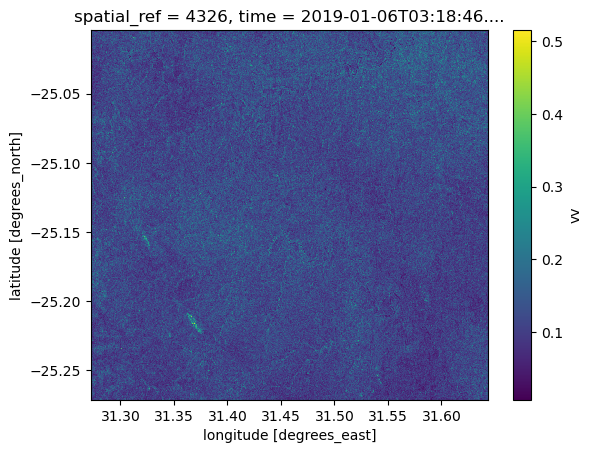

In [8]:
#ds_40.isel(time=0).vv.plot()

In [9]:
ds_40.vv

<xarray.DataArray 'vv' (time: 258, latitude: 668, longitude: 927)>
dask.array<mean_agg-aggregate, shape=(258, 668, 927), dtype=float32, chunksize=(258, 255, 255), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.0 -25.0 -25.01 ... -25.27 -25.27 -25.27
  * longitude    (longitude) float64 31.27 31.27 31.27 ... 31.64 31.64 31.64
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2021-12...

In [10]:
'''
ds_ymin = float(ds.latitude.min().values)
ds_ymax = float(ds.latitude.max().values)
ds_xmin = float(ds.longitude.min().values)
ds_xmax = float(ds.longitude.max().values)
ds_xmin, ds_xmax, ds_ymin, ds_ymax
'''

'\nds_ymin = float(ds.latitude.min().values)\nds_ymax = float(ds.latitude.max().values)\nds_xmin = float(ds.longitude.min().values)\nds_xmax = float(ds.longitude.max().values)\nds_xmin, ds_xmax, ds_ymin, ds_ymax\n'

In [11]:
#clip ds on given bounds

In [12]:
#ds_clip = ds.where((ds.latitude >= ymin) & (ds.latitude <= ymax) & (ds.longitude >= xmin) & (ds.longitude <= xmax), drop=True)

In [13]:
#6-9
ds_clip = ds_40.sel(time=ds_40.time.dt.month.isin([6,7,8,9]))

In [14]:
ds_clip


<xarray.Dataset>
Dimensions:      (time: 86, latitude: 668, longitude: 927)
Coordinates:
  * latitude     (latitude) float64 -25.0 -25.0 -25.01 ... -25.27 -25.27 -25.27
  * longitude    (longitude) float64 31.27 31.27 31.27 ... 31.64 31.64 31.64
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-06-03T16:30:37.017705 ... 2021-09...
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(86, 255, 255), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(86, 255, 255), meta=np.ndarray>
    area         (time, latitude, longitude) float32 dask.array<chunksize=(86, 255, 255), meta=np.ndarray>

In [26]:
ds_month_min = ds_clip.resample(time='1M').min(dim='time')
ds_month_max = ds_clip.resample(time='1M').max(dim='time')
ds_month_mean = ds_clip.resample(time='1M').mean(dim='time')
ds_month_median = ds_clip.resample(time='1M').median(dim='time')
ds_month_std = ds_clip.resample(time='1M').std(dim='time')


ds_month_quantiles = ds_clip.resample(time='1M').quantile(dim='time', q=[0.05, 0.25, 0.5, 0.75, 0.95])


In [18]:
#from sdc.utils import ds_nanquantiles
#ds_month_quantiles = ds_nanquantiles(ds = ds_clip, quantiles=(0.05,0.25,0.75,0.95))




In [12]:
### berechne RVI
ds_clip_rvi = (4*ds_clip.vh)/(ds_clip.vv+ds_clip.vh)

In [13]:
#features for RVI
ds_month_rvi_min = ds_clip_rvi.resample(time='1M').min(dim='time')
ds_month_rvi_max = ds_clip_rvi.resample(time='1M').max(dim='time')
ds_month_rvi_mean = ds_clip_rvi.resample(time='1M').mean(dim='time')
ds_month_rvi_median = ds_clip_rvi.resample(time='1M').median(dim='time')
ds_month_rvi_std = ds_clip_rvi.resample(time='1M').std(dim='time')
ds_month_rvi_quantiles = ds_clip_rvi.resample(time='1M').quantile(dim='time', q=[0.05, 0.25, 0.5, 0.75, 0.95])

In [14]:
#ds_clip_rvi.isel(time=0).values

In [15]:
#ds_clip_rvi.isel(time=0).plot()

In [16]:
%%time
#list_min_vv = []
#list_min_vh = []
#list_pix = []
def get_pixel_lists(ds):
    liste = []
    for i in range(len(gdf_recl_lo)):
        ex = gdf_recl_lo["geometry"].iloc[i].coords[0]
        pix = ds.sel(latitude=ex[0], longitude=ex[1], method='nearest')#.vv.compute()
        time = gdf_recl_lo["Acquisition Time"].iloc[i]
        liste.append(pix.sel(time=time, method='nearest'))#.compute()))
        liste[i] = float(liste[i])
    return liste

CPU times: user 0 ns, sys: 28 µs, total: 28 µs
Wall time: 54.6 µs


In [43]:
%%time

ds_month_min_vv = ds_month_min.vv.compute()
gdf_recl_lo['min_vv'] = get_pixel_lists(ds=ds_month_min_vv)

CPU times: user 8min 14s, sys: 38.8 s, total: 8min 52s
Wall time: 6min 59s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [45]:
%%time
ds_month_max_vv = ds_month_max.vv.compute()
gdf_recl_lo['max_vv'] = get_pixel_lists(ds=ds_month_max_vv)

CPU times: user 8min 14s, sys: 36.3 s, total: 8min 51s
Wall time: 7min 16s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [46]:
%%time
ds_month_mean_vv = ds_month_mean.vv.compute()
gdf_recl_lo['mean_vv'] = get_pixel_lists(ds=ds_month_mean_vv)

CPU times: user 7min 50s, sys: 32.8 s, total: 8min 23s
Wall time: 6min 37s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [47]:
%%time
ds_month_median_vv = ds_month_median.vv.compute()
gdf_recl_lo['median_vv'] = get_pixel_lists(ds=ds_month_median_vv)

CPU times: user 8min 2s, sys: 34.5 s, total: 8min 36s
Wall time: 6min 40s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
%%time
ds_month_std_vv = ds_month_std.vv.compute()
gdf_recl_lo['std_vv'] = get_pixel_lists(ds=ds_month_std_vv)

CPU times: user 8min 2s, sys: 37.6 s, total: 8min 39s
Wall time: 7min 16s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
%%time
ds_month_05_vv = ds_month_quantiles.vv.sel(quantile=0.05).compute()
gdf_recl_lo['05_vv'] = get_pixel_lists(ds=ds_month_05_vv)

CPU times: user 10min 35s, sys: 50.3 s, total: 11min 25s
Wall time: 47min 25s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [50]:
%%time
ds_month_25_vv = ds_month_quantiles.vv.sel(quantile=0.25).compute()
gdf_recl_lo['25_vv'] = get_pixel_lists(ds=ds_month_25_vv)

CPU times: user 9min 47s, sys: 54.8 s, total: 10min 42s
Wall time: 48min 32s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
%%time
ds_month_75_vv = ds_month_quantiles.vv.sel(quantile=0.75).compute()
gdf_recl_lo['75_vv'] = get_pixel_lists(ds=ds_month_75_vv)

CPU times: user 8min 41s, sys: 45.9 s, total: 9min 27s
Wall time: 46min 58s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [69]:
%%time
ds_month_95_vv = ds_month_quantiles.vv.sel(quantile=0.95).compute()
gdf_recl_lo['95_vv'] = get_pixel_lists(ds=ds_month_95_vv)

CPU times: user 9min 52s, sys: 56 s, total: 10min 48s
Wall time: 50min 9s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [70]:
%%time
ds_month_min_vh = ds_month_min.vh.compute()
gdf_recl_lo['min_vh'] = get_pixel_lists(ds=ds_month_min_vh)

CPU times: user 8min 28s, sys: 40.8 s, total: 9min 9s
Wall time: 6min 50s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [71]:
%%time
ds_month_max_vh = ds_month_max.vh.compute()
gdf_recl_lo['max_vh'] = get_pixel_lists(ds=ds_month_max_vh)

CPU times: user 8min 32s, sys: 41.1 s, total: 9min 13s
Wall time: 8min 19s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [72]:
%%time
ds_month_mean_vh = ds_month_mean.vh.compute()
gdf_recl_lo['mean_vh'] = get_pixel_lists(ds=ds_month_mean_vh)

CPU times: user 8min 12s, sys: 40 s, total: 8min 52s
Wall time: 6min 48s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [73]:
%%time
ds_month_median_vh = ds_month_median.vh.compute()
gdf_recl_lo['median_vh'] = get_pixel_lists(ds=ds_month_median_vh)

CPU times: user 8min 13s, sys: 40 s, total: 8min 53s
Wall time: 6min 50s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [74]:
%%time
ds_month_std_vh = ds_month_std.vh.compute()
gdf_recl_lo['std_vh'] = get_pixel_lists(ds=ds_month_std_vh)

CPU times: user 8min 23s, sys: 41.4 s, total: 9min 4s
Wall time: 6min 51s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [75]:
%%time
ds_month_05_vh = ds_month_quantiles.vh.sel(quantile=0.05).compute()
gdf_recl_lo['05_vh'] = get_pixel_lists(ds=ds_month_05_vh)

CPU times: user 9min 44s, sys: 56.1 s, total: 10min 40s
Wall time: 46min 1s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
%%time
ds_month_25_vh = ds_month_quantiles.vh.sel(quantile=0.25).compute()
gdf_recl_lo['25_vh'] = get_pixel_lists(ds=ds_month_25_vh)

CPU times: user 11min 47s, sys: 52.9 s, total: 12min 40s
Wall time: 46min 37s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [27]:
%%time
ds_month_75_vh = ds_month_quantiles.vh.sel(quantile=0.75).compute()
gdf_recl_lo['75_vh'] = get_pixel_lists(ds=ds_month_75_vh)

KilledWorker: Attempted to run task ('broadcast_to-concatenate-transpose-wrapper-wrapper_0-getitem-b216eccdd21350f25a3f4302f6704b15', 11, 0, 1, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://172.18.1.9:38879. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [34]:
%%time
ds_month_95_vh = ds_month_quantiles.vh.sel(quantile=0.95).compute()
gdf_recl_lo['95_vh'] = get_pixel_lists(ds=ds_month_95_vh)

CPU times: user 9min 29s, sys: 54.7 s, total: 10min 24s
Wall time: 47min 27s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
%%time
ds_month_rvi_min = ds_month_rvi_min.compute()
gdf_recl_lo['min_rvi'] = get_pixel_lists(ds=ds_month_rvi_min)

CPU times: user 7min 43s, sys: 33.9 s, total: 8min 17s
Wall time: 6min 44s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
%%time
ds_month_rvi_max = ds_month_rvi_max.compute()
gdf_recl_lo['max_rvi'] = get_pixel_lists(ds=ds_month_rvi_max)

CPU times: user 8min 12s, sys: 36.4 s, total: 8min 49s
Wall time: 7min 4s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
%%time
ds_month_rvi_mean = ds_month_rvi_mean.compute()
gdf_recl_lo['mean_rvi'] = get_pixel_lists(ds=ds_month_rvi_mean)

CPU times: user 8min 7s, sys: 37.8 s, total: 8min 45s
Wall time: 6min 50s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
%%time
ds_month_rvi_median = ds_month_rvi_median.compute()
gdf_recl_lo['median_rvi'] = get_pixel_lists(ds=ds_month_rvi_median)

CPU times: user 8min 16s, sys: 35 s, total: 8min 51s
Wall time: 7min 4s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
%%time
ds_month_rvi_std = ds_month_rvi_std.compute()
gdf_recl_lo['std_rvi'] = get_pixel_lists(ds=ds_month_rvi_std)

CPU times: user 7min 18s, sys: 28.5 s, total: 7min 46s
Wall time: 6min 23s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [40]:
%%time
ds_month_rvi_05 = ds_month_rvi_quantiles.sel(quantile=0.05).compute()
gdf_recl_lo['05_rvi'] = get_pixel_lists(ds=ds_month_rvi_05)

CPU times: user 9min 41s, sys: 56.6 s, total: 10min 38s
Wall time: 50min 16s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
%%time
ds_month_rvi_25 = ds_month_rvi_quantiles.sel(quantile=0.25).compute()
gdf_recl_lo['25_rvi'] = get_pixel_lists(ds=ds_month_rvi_25)

CPU times: user 9min 38s, sys: 54.8 s, total: 10min 33s
Wall time: 48min 3s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [42]:
%%time
ds_month_rvi_75 = ds_month_rvi_quantiles.sel(quantile=0.75).compute()
gdf_recl_lo['75_rvi'] = get_pixel_lists(ds=ds_month_rvi_75)

CPU times: user 9min 16s, sys: 48 s, total: 10min 4s
Wall time: 46min 53s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
%%time
ds_month_rvi_95 = ds_month_rvi_quantiles.sel(quantile=0.95).compute()
gdf_recl_lo['95_rvi'] = get_pixel_lists(ds=ds_month_rvi_95)

CPU times: user 9min 52s, sys: 1min 1s, total: 10min 54s
Wall time: 52min 53s


/home/ga59wig/micromamba/envs/geo419b_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
######               27 features

In [18]:
gdf_recl_lo.to_file('gdf_recl_lo_res.gpkg', driver='GPKG')